In [1]:
# Imports
from charles.charles import Individual, Population
from charles.utils import get_fitness
from charles.selection import tournament, fitness_proportional, ranking
from charles.crossover import co_on_common_node, co_on_two_common_nodes
from charles.mutation import tail_mutation, middle_mutation
from data.example_graphs import *
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product

In [6]:
# Set variables
random_state = 1
target_graph = g4
plt.style.use('ggplot')

# Monkey patching the fitness method of Individual
Individual.get_fitness = get_fitness

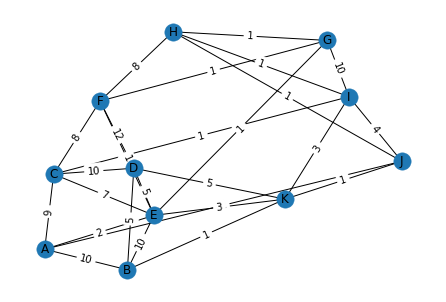

In [7]:
# Visualize the target graph
pos = nx.spring_layout(target_graph, seed=random_state)
nx.draw(target_graph, pos=pos, with_labels=True)
nx.draw_networkx_edge_labels(
  target_graph,
  pos=pos,
  edge_labels={(u, v): int(d['weight']) for u, v, d in target_graph.edges(data=True)}
);

In [4]:
# Instantiating a population and running the GA
# pop = Population(
#   size=5,
#   target_graph=target_graph,
#   optim='min', 
# )

# evolution_log = pop.evolve(
#     gens=100,
#     select=tournament,
#     crossover=co_on_common_node,
#     mutate=tail_mutation,
#     co_p=0.9,
#     mu_p=0.1,
#     elitism=True,
#     verbose=False
# )

In [5]:
# for i in pop:
#     print(i.fitness)

In [6]:
# Checking the evolution of the population
# for log in evolution_log:
#   print(f'Generation: {log[0]}, Fitness {log[1]}, Representation: {log[2]}') # Print representation
  # print(f'Generation: {log[0]}, Fitness {log[1]}') # Don't print representation

In [7]:
# Checking each individual in the population
# for i in pop:
#   print(i)
#   print(i.penalizations, '\n')

In [8]:
# Checking out a single individual in the population
# ind1 = pop[0]

# ind1

## Comparing different configurations of our GA

Running multiple iterations of each configuration of our GA, to compare their performance

In [9]:
selection_options = [
  tournament,
  fitness_proportional,
  ranking,
]

crossover_options = [
  co_on_common_node,
  co_on_two_common_nodes,
]

mutation_options = [
  tail_mutation,
  middle_mutation,
]

elitism_options = [
  True,
  False,
]

# Create a grid of all possible combinations of the above variables
config_df = pd.DataFrame(
  list(
    product(
      selection_options,
      crossover_options,
      mutation_options,
      elitism_options,
    )
  ),
  columns=['selection', 'crossover', 'mutation', 'elitism']
)

In [10]:
# Create empty dataframe with the columns: 'iteration',
# 'generation', 'fitness', 'representation'
iterated_evolution_log_df = pd.DataFrame(columns=[
  'iteration',
  'generation',
  'fitness',
  'representation',
  'config',
])

for c in range(config_df.shape[0]):
  config = f"selection:{config_df.iloc[c, 0].__name__}, crossover:{config_df.iloc[c, 1].__name__}, mutation:{config_df.iloc[c, 2].__name__}, elitism:{config_df.iloc[c, 3]}"

  for iteration_number in range(100):
    pop = Population(
      size=10,
      target_graph=target_graph,
      optim='min', 
    )

    evolution_log = pop.evolve(
        gens=100,
        select=config_df.iloc[c, 0],
        crossover=config_df.iloc[c, 1],
        mutate=config_df.iloc[c, 2],
        co_p=0.9,
        mu_p=0.1,
        elitism=config_df.iloc[c, 3],
        verbose=False
    )

    # Convert evolution_log to a dataframe
    evolution_log_df = (
      pd.DataFrame(
        data=evolution_log,
        columns=['generation', 'fitness', 'representation']
      )
      .assign(
        iteration=iteration_number,
        config=config
      )
      .loc[
        :,
        [
        'iteration',
        'generation',
        'fitness',
        'representation',
        'config',
        ]
      ]
    )

    # Append evolution_log_df to iterated_evolution_log_df
    iterated_evolution_log_df = (
      pd.concat(
        objs=[iterated_evolution_log_df, evolution_log_df],
        axis=0,
        ignore_index=True
      )
    )

In [11]:
# Save iterated_evolution_log_df to a csv file, so we don't have
# to re-run the GA every time
iterated_evolution_log_df.to_csv(
  'data/iterated_evolution_log_df.csv',
  index=False
)

# Reading the csv file
iterated_evolution_log_df = pd.read_csv('data/iterated_evolution_log_df.csv')

Checking out the mean fitness of the final generation of the different configurations:

In [12]:
(
  iterated_evolution_log_df
  .query('generation == 100')
  .groupby('config')
  .agg({'fitness': 'mean'})
  .sort_values('fitness')
)

,fitness
config,
"selection:tournament, crossover:co_on_two_common_nodes, mutation:tail_mutation, elitism:True",166.31
"selection:ranking, crossover:co_on_two_common_nodes, mutation:middle_mutation, elitism:True",167.34
"selection:tournament, crossover:co_on_two_common_nodes, mutation:middle_mutation, elitism:True",168.83
"selection:ranking, crossover:co_on_two_common_nodes, mutation:tail_mutation, elitism:True",170.07
"selection:ranking, crossover:co_on_common_node, mutation:middle_mutation, elitism:True",175.48
"selection:tournament, crossover:co_on_common_node, mutation:middle_mutation, elitism:True",179.12
"selection:tournament, crossover:co_on_common_node, mutation:tail_mutation, elitism:True",179.31
"selection:ranking, crossover:co_on_common_node, mutation:tail_mutation, elitism:True",181.80
"selection:tournament, crossover:co_on_common_node, mutation:middle_mutation, elitism:False",188.23


Text(0, 0.5, 'Configuration')

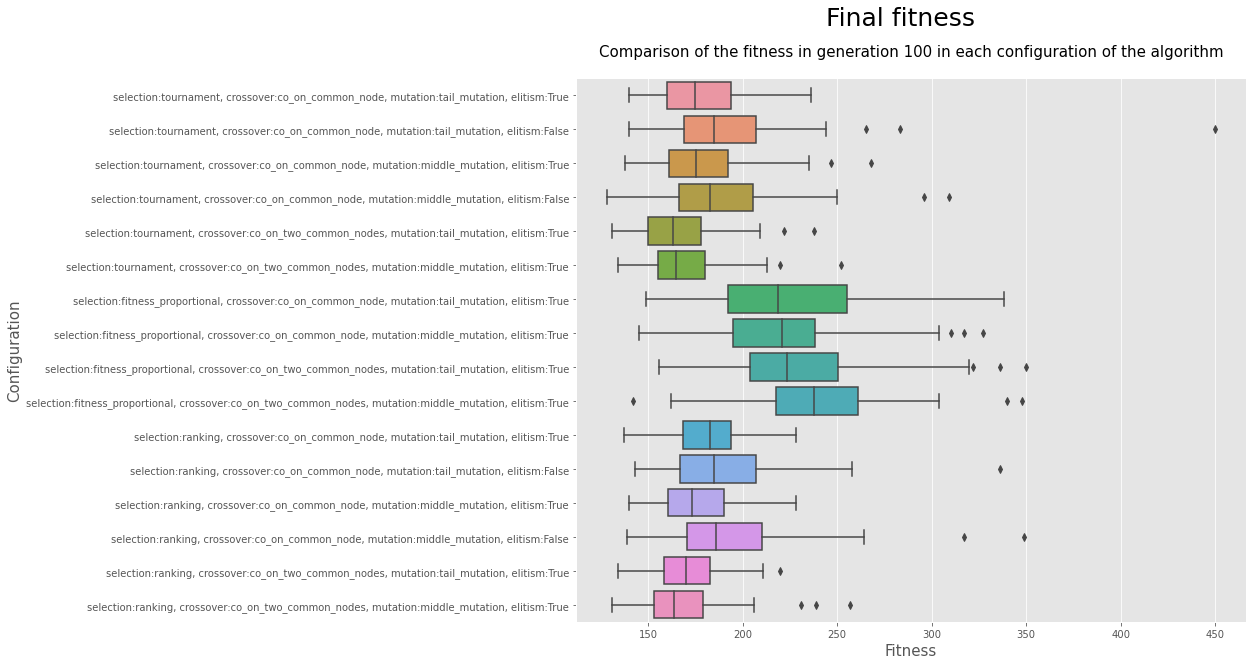

In [26]:
plot_df = (
  iterated_evolution_log_df
  .query('generation == 100')
  # Filtering out configurations that didn't converge
  .query('config != "selection:tournament, crossover:co_on_two_common_nodes, mutation:tail_mutation, elitism:False"')
  .query('config != "selection:ranking, crossover:co_on_two_common_nodes, mutation:middle_mutation, elitism:False"')
  .query('config != "selection:ranking, crossover:co_on_two_common_nodes, mutation:tail_mutation, elitism:False"')
  .query('config != "selection:tournament, crossover:co_on_two_common_nodes, mutation:middle_mutation, elitism:False"')
  .query('config != "selection:fitness_proportional, crossover:co_on_two_common_nodes, mutation:middle_mutation, elitism:False"')
  .query('config != "selection:fitness_proportional, crossover:co_on_two_common_nodes, mutation:tail_mutation, elitism:False"')
  .query('config != "selection:fitness_proportional, crossover:co_on_common_node, mutation:tail_mutation, elitism:False"')
  .query('config != "selection:fitness_proportional, crossover:co_on_common_node, mutation:middle_mutation, elitism:False"')
)

fig, ax = plt.subplots(figsize=(12, 10))

sns.boxplot(
  x='fitness',
  y='config',
  data=plot_df,
)

# Titles and labels
plt.suptitle('Final fitness', fontsize=25)
plt.title(
  'Comparison of the fitness in generation 100 in each configuration of the algorithm',
  fontsize=15,
  y=1.03
)
plt.xlabel('Fitness', fontsize=15)
plt.ylabel('Configuration', fontsize=15)

C:\Users\marcelo.jannuzzi\AppData\Local\Temp\ipykernel_17584\3679335515.py:44: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  plt.plot((lower, upper), (y, y), 'r-', color=red)


Text(0, 0.5, 'Configuration')

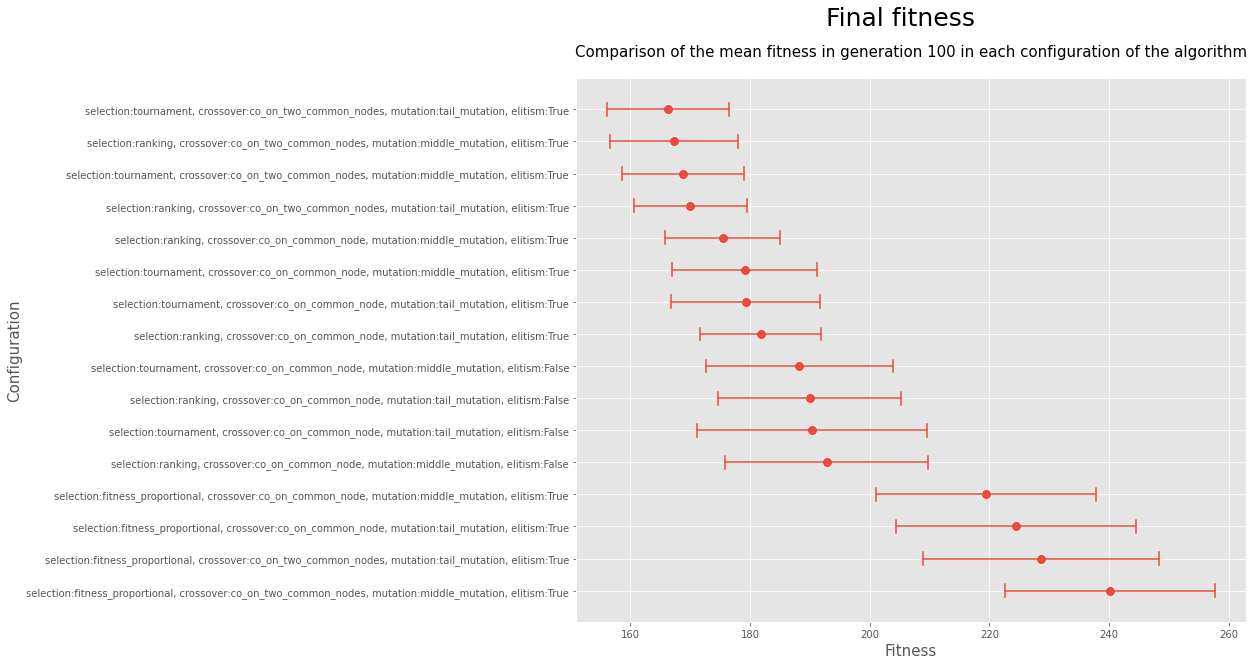

In [30]:
plot_df = (
  iterated_evolution_log_df
  .query('generation == 100')
  # Filtering out configurations that didn't converge
  .query('config != "selection:tournament, crossover:co_on_two_common_nodes, mutation:tail_mutation, elitism:False"')
  .query('config != "selection:ranking, crossover:co_on_two_common_nodes, mutation:middle_mutation, elitism:False"')
  .query('config != "selection:ranking, crossover:co_on_two_common_nodes, mutation:tail_mutation, elitism:False"')
  .query('config != "selection:tournament, crossover:co_on_two_common_nodes, mutation:middle_mutation, elitism:False"')
  .query('config != "selection:fitness_proportional, crossover:co_on_two_common_nodes, mutation:middle_mutation, elitism:False"')
  .query('config != "selection:fitness_proportional, crossover:co_on_two_common_nodes, mutation:tail_mutation, elitism:False"')
  .query('config != "selection:fitness_proportional, crossover:co_on_common_node, mutation:tail_mutation, elitism:False"')
  .query('config != "selection:fitness_proportional, crossover:co_on_common_node, mutation:middle_mutation, elitism:False"')
  .groupby('config')
  .agg({'fitness': ['mean', 'std']})
  .droplevel(0, axis=1)
  .rename(columns={
    'mean': 'mean_fitness',
    'std': 'std_fitness',
  })
  .assign(
    ci_lower=lambda x: x['mean_fitness'] - 1.96 * x['std_fitness']/np.sqrt(x.shape[0]),
    ci_upper=lambda x: x['mean_fitness'] + 1.96 * x['std_fitness']/np.sqrt(x.shape[0]),
  )
  .reset_index()
  .sort_values('mean_fitness')
)

# Plotting the mean fitness and confidence interval for each configuration
fig, ax = plt.subplots(figsize=(12, 10))

red = '#e74c3c'

# Points
sns.scatterplot(
  data=plot_df,
  x='mean_fitness',
  y='config',
  s=100,
  color=red,
)

# Confidence intervals
for lower, upper, y in zip(plot_df['ci_lower'], plot_df['ci_upper'], range(plot_df.shape[0])):
    plt.plot((lower, upper), (y, y), 'r-', color=red)
    plt.plot((lower, lower), (y-0.2, y+0.2), color=red)
    plt.plot((upper, upper), (y-0.2, y+0.2), color=red)

# Titles and labels
plt.suptitle('Final fitness', fontsize=25)
plt.title(
  'Comparison of the mean fitness in generation 100 in each configuration of the algorithm',
  fontsize=15,
  y=1.03
)
plt.xlabel('Fitness', fontsize=15)
plt.ylabel('Configuration', fontsize=15)

Plotting the evolution of the mean fitness over generations, for each configuration:

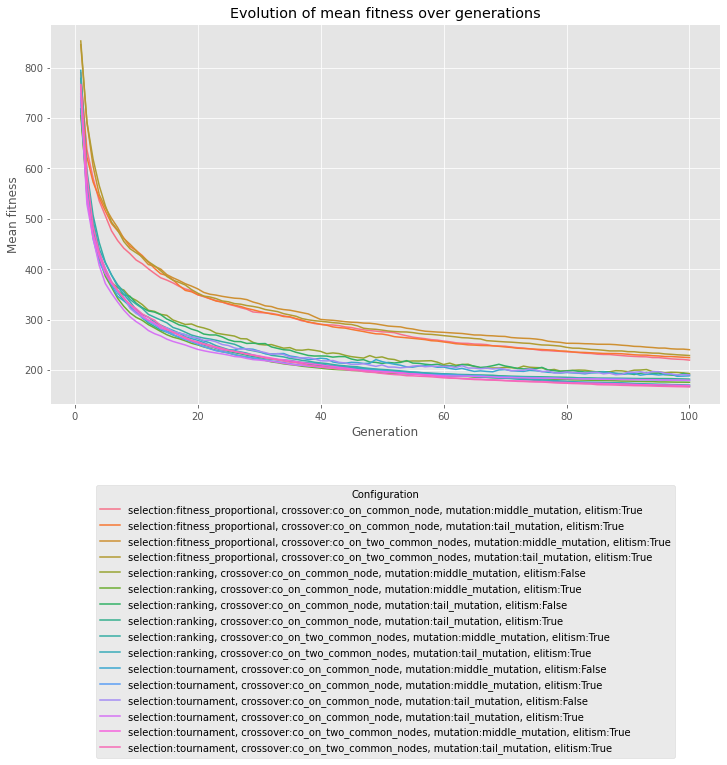

In [19]:
# The data
plot_df = (
  iterated_evolution_log_df
  .groupby([
    'config',
    'generation',
  ])
  .agg({'fitness': 'mean'})
  .reset_index()
  # Filtering out configurations that didn't converge
  .query('config != "selection:tournament, crossover:co_on_two_common_nodes, mutation:tail_mutation, elitism:False"')
  .query('config != "selection:ranking, crossover:co_on_two_common_nodes, mutation:middle_mutation, elitism:False"')
  .query('config != "selection:ranking, crossover:co_on_two_common_nodes, mutation:tail_mutation, elitism:False"')
  .query('config != "selection:tournament, crossover:co_on_two_common_nodes, mutation:middle_mutation, elitism:False"')
  .query('config != "selection:fitness_proportional, crossover:co_on_two_common_nodes, mutation:middle_mutation, elitism:False"')
  .query('config != "selection:fitness_proportional, crossover:co_on_two_common_nodes, mutation:tail_mutation, elitism:False"')
  .query('config != "selection:fitness_proportional, crossover:co_on_common_node, mutation:tail_mutation, elitism:False"')
  .query('config != "selection:fitness_proportional, crossover:co_on_common_node, mutation:middle_mutation, elitism:False"')
  # Filtering out other configurations
)

# The plot
fig, ax = plt.subplots(figsize=(12, 7))

sns.lineplot(
  x='generation',
  y='fitness',
  data=plot_df,
  hue='config',
)

# Set graph options
ax.set_title('Evolution of mean fitness over generations')
ax.set_ylabel('Mean fitness')
ax.set_xlabel('Generation')

# Place legend outside of the plot, at bottom
(
  ax
  .legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.2),
    ncol=1
  )
  .set_title('Configuration')
)

In [16]:
# (
#   iterated_evolution_log_df
#   .query('config == "selection:fitness_proportional, crossover:co_on_common_node, mutation:tail_mutation, elitism:True"')
#   .query('generation == 100')
#   .sort_values('fitness', ascending=True)
# )